In [1]:
%load_ext autoreload
%autoreload 2

from src import *

No module named 'gurobipy'


### File loading

In [2]:
files = {
    0: ['08-OUT-ALL', 1],
    1: ['09-IN-ALL', 1],
    2: ['11-IN-ALL', 1],
    3: ['05-IN-ALL', 1],
    4: ['06-IN-ALL', 1],
}
file = files[2]
# uuid = '042_large_dataset_1000/0'
uuid = '047_october/0'
model_name = 'rvce'

model, config = load_model_locally(uuid, model_name=model_name, device='cuda:0')
video = Video(file, config)

from_time, till_time = video.get_from_till_time(Part.WHOLE)

predictions, probabilities = validate_video(video, model, from_time=from_time, till_time=till_time, return_probs=True, tqdm=tqdm)
labels = get_labels(video, from_time, till_time)

  0%|          | 0/8027 [00:00<?, ?it/s]

### Statistics

In [3]:
events_intervals = video.events_end_time - video.events_start_time
print('Number of events:', len(events_intervals))
print('Mean length:     ', np.mean(events_intervals)) 
print('Median length:   ', np.median(events_intervals))
print('Max length:      ', np.max(events_intervals))

Number of events: 1918
Mean length:      4.203128258602704
Median length:    4.239999999997963
Max length:       11.159999999999854


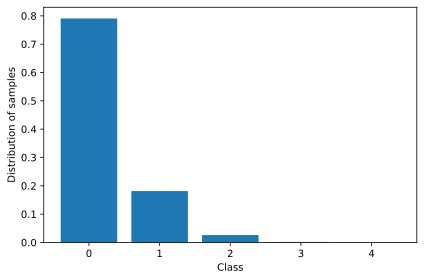

In [4]:
plot_class_distribution(labels["n_counts"], normalized=True)
set_plt_svg()

In [5]:
print("all windows * window length:")
print(time_formatter(predictions['n_counts'].shape[0] * config.window_length))
print()
print("empty windows * window length:")
print(time_formatter(np.sum(labels["n_counts"] == 0) * config.window_length))

all windows * window length:
13:22:42

empty windows * window length:
10:34:48


pred: 1632 	 true: 1918 	 rvce: 0.149


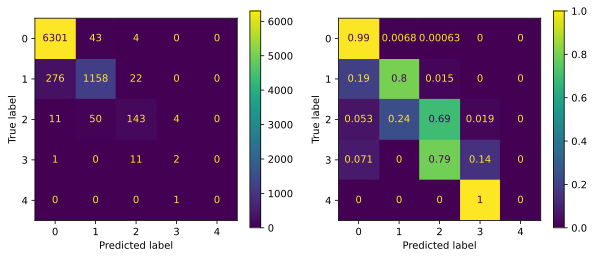

In [6]:
plot_confusion_matrix(labels['n_counts'], predictions['n_counts'])
set_plt_svg()

### Time savings using energy thresholding 

In [7]:
features = torch.stft(video.get_signal(), n_fft=config.n_fft, hop_length=config.hop_length)
energy = features[..., 0].pow(2)
energy = energy.sum(0)

energies = []

n_hops = get_n_hops(config, from_time, till_time)

factor = len(energy) / n_hops

for i in tqdm(range(n_hops)):
    
    E = energy[round(i * factor): round((i + 1) * factor)].max()
    # E = energy[round(i * factor): round((i + 1) * factor)].mean()
    # E = energy[round(i * factor): round((i + 1) * factor)].min()
    
    energies.append(E)

energies = np.array(energies)

  0%|          | 0/8027 [00:00<?, ?it/s]

error 0.050 = 84/1679    confidence: 0.48590
error 0.000 = 0/1679    confidence: 1.00000

error 0.050 = 84/1679    time saved: 00:08:36
error 0.001 = 1/1679    time saved: 00:00:00


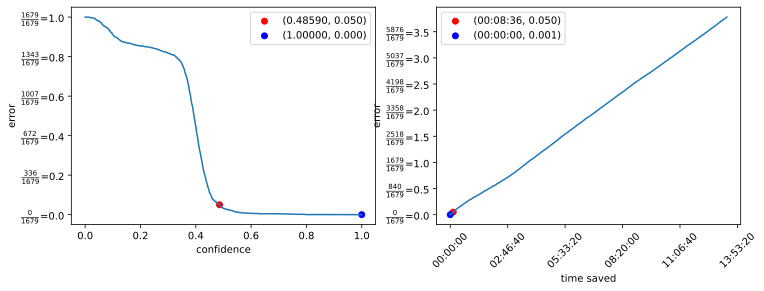

In [8]:
probs_0 = np.array(energies)
probs_0 = (probs_0 - probs_0.min()) / (probs_0.max() - probs_0.min())
y_true = np.array(labels['n_counts'])
# y_pred = predictions['n_counts'].copy()

## set error threshold (y axis)
ERROR_THRESHOLD = 0.05
## set confidence (x axis)
CONFIDENCE = 0.99999
## set neighborhood size
EVENTS_NEIGHBOURHOOD = 1
## either use windows for statistics of events
STATISTICS_ON_WINDOWS = False

# kernel = np.full(2 * EVENTS_NEIGHBOURHOOD + 1, True)
# mask = y_pred != 0
# mask = np.convolve(mask, kernel, mode='same')
# mask = ~mask
# probs_0 = probs_0[mask]
# y_true = y_true[mask]
# y_pred = y_pred[mask]

## if we assume that the operator wants to reduce the time when visual engine
## does not detect anything, we can take only those windows with no cars 
## according to audio engine and measure the error
# mask = y_pred == 0
# probs_0 = probs_0[mask]
# y_true = y_true[mask]
# y_pred = y_pred[mask]

# indices = probs_0.argsort()[::-1]

y_true_mask = (y_true == 0).astype(int)
n_events = (y_true != 0).sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ps = np.unique(probs_0)
# ps = np.linspace(0, 1, 1000)
ys = []
for p in ps:
    mask = probs_0 >= p
    # y = y_true_mask[mask].sum()
    y_pred_mask = (probs_0 >= p).astype(int)
    y = np.sum(np.abs(y_true_mask[mask] - y_pred_mask[mask]))
    ys.append(y)

## normalize with number of windows with events
ys_normalized = np.array(ys) / n_events

i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
axes[0].scatter(ps[i], ys_normalized[i], label=f"({ps[i]:.5f}, {ys_normalized[i]:.3f})", c='r')
axes[0].plot(ps, ys_normalized)
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    confidence: {ps[i]:.5f}')
axes[0].set_ylabel("error")
axes[0].set_xlabel("confidence")

j = np.argmin(np.abs(ps - CONFIDENCE))
error_for_selected_confidence = ys_normalized[j]
axes[0].scatter(ps[j], error_for_selected_confidence, label=f"({ps[j]:.5f}, {error_for_selected_confidence:.3f})", c='b')
print(f'error {error_for_selected_confidence:.3f} = {ys[j]}/{n_events}    confidence: {ps[j]:.5f}')
print()


axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)

xs = np.arange(len(y_true_mask)) * config.window_length
# cummulative error
ys = np.cumsum(np.abs(y_true_mask - y_pred_mask))
## normalize with number of windows with events
ys_normalized = ys / n_events

axes[1].plot(xs, ys_normalized)
axes[1].xaxis.set_major_formatter(tick.FuncFormatter(time_formatter))

def error_formatter(x, *args):
    return r'$\frac{' + f'{x * n_events:.0f}' + r'}{' + f'{n_events}' + r'}$' + f'={x:.1f}'

axes[0].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))
axes[1].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))

# ? find place where error is equal to ERROR_THRESHOLD
i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')
axes[1].set_ylabel("error")
axes[1].set_xlabel("time saved")
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='r')

# ? find place where confidence is equal to CONFIDENCE
i = np.argmin(np.abs(ys_normalized - error_for_selected_confidence))
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='b')
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')

for ax in axes:
    ax.legend()

set_plt_svg()

### Time savings using NN predictions

error 0.050 = 10/200    confidence: 0.99918
error 0.005 = 1/200    confidence: 0.99999

error 0.050 = 10/200    time saved: 06:35:42
error 0.005 = 1/200    time saved: 00:43:36


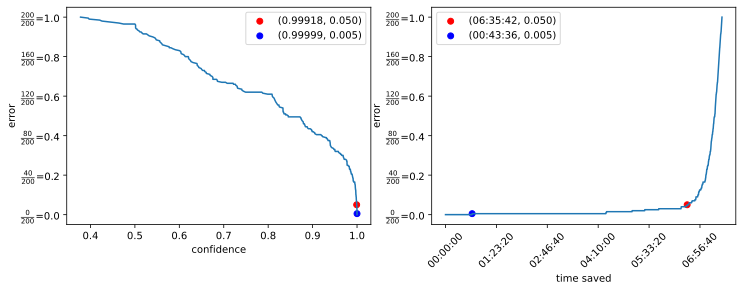

In [9]:
probs_0 = np.array(probabilities['n_counts'][:, 0])
y_true = np.array(labels['n_counts'])
y_pred = np.array(predictions['n_counts'])

## set error threshold (y axis)
ERROR_THRESHOLD = 0.05
## set confidence (x axis)
CONFIDENCE = 0.99999
## set neighborhood size
EVENTS_NEIGHBOURHOOD = 1
## either use windows for statistics of events
STATISTICS_ON_WINDOWS = False

kernel = np.full(2 * EVENTS_NEIGHBOURHOOD + 1, True)
mask = y_pred != 0
mask = np.convolve(mask, kernel, mode='same')
mask = ~mask
probs_0 = probs_0[mask]
y_true = y_true[mask]
y_pred = y_pred[mask]

## if we assume that the operator wants to reduce the time when visual engine
## does not detect anything, we can take only those windows with no cars 
## according to audio engine and measure the error
# mask = y_pred == 0
# probs_0 = probs_0[mask]
# y_true = y_true[mask]
# y_pred = y_pred[mask]

indices = probs_0.argsort()[::-1]

if STATISTICS_ON_WINDOWS:
    y_true_mask = y_true == 0
    y_pred_mask = y_pred == 0
    n_events = (y_true != 0).sum()
else:
    y_true_mask = y_true
    y_pred_mask = y_pred
    n_events = y_true[y_true != 0].sum()

y_true_mask = y_true_mask[indices].astype(int)
y_pred_mask = y_pred_mask[indices].astype(int)
probs_0 = probs_0[indices]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ps = np.unique(probs_0)
# ps = np.linspace(0, 1, 1000)
ys = []
for p in ps:
    mask = probs_0 >= p
    # y = y_true_mask[mask].sum()
    y = np.sum(np.abs(y_true_mask[mask] - y_pred_mask[mask]))
    ys.append(y)

## normalize with number of windows with events
ys_normalized = np.array(ys) / n_events

i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
axes[0].scatter(ps[i], ys_normalized[i], label=f"({ps[i]:.5f}, {ys_normalized[i]:.3f})", c='r')
axes[0].plot(ps, ys_normalized)
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    confidence: {ps[i]:.5f}')
axes[0].set_ylabel("error")
axes[0].set_xlabel("confidence")

j = np.argmin(np.abs(ps - CONFIDENCE))
error_for_selected_confidence = ys_normalized[j]
axes[0].scatter(ps[j], error_for_selected_confidence, label=f"({ps[j]:.5f}, {error_for_selected_confidence:.3f})", c='b')
print(f'error {error_for_selected_confidence:.3f} = {ys[j]}/{n_events}    confidence: {ps[j]:.5f}')
print()


axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)

xs = np.arange(len(y_true_mask)) * config.window_length
# cummulative error
ys = np.cumsum(np.abs(y_true_mask - y_pred_mask))
# y = cumerror / len(y_true_mask)
## normalize with number of windows with events
ys_normalized = ys / n_events
axes[1].plot(xs, ys_normalized)
axes[1].xaxis.set_major_formatter(tick.FuncFormatter(time_formatter))

def error_formatter(x, *args):
    return r'$\frac{' + f'{x * n_events:.0f}' + r'}{' + f'{n_events}' + r'}$' + f'={x:.1f}'

axes[0].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))
axes[1].yaxis.set_major_formatter(tick.FuncFormatter(error_formatter))

# ? find place where error is equal to ERROR_THRESHOLD
i = np.argmin(np.abs(ys_normalized - ERROR_THRESHOLD))
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')
axes[1].set_ylabel("error")
axes[1].set_xlabel("time saved")
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='r')

# ? find place where confidence is equal to CONFIDENCE
i = np.argmin(np.abs(ys_normalized - error_for_selected_confidence))
axes[1].scatter(xs[i], ys_normalized[i], label=f"({time_formatter(xs[i])}, {ys_normalized[i]:.3f})", c='b')
print(f'error {ys_normalized[i]:.3f} = {ys[i]}/{n_events}    time saved: {time_formatter(xs[i])}')

for ax in axes:
    ax.legend()

set_plt_svg()

### Fault detection

In [10]:
def calculate_cum_errs_video_fault(y_pred, y_true):
    cum_errs = []
    cum_err = 0
    for yp, yt in zip(y_pred, y_true):
        if yp == yt and yp != 0:
            cum_err = 0
        elif yp != yt and yt != 0:
            cum_err = 0
        else:
            cum_err += yp - yt
        cum_errs.append(cum_err)
    return np.array(cum_errs)


def calculate_cum_errs_audio_fault(y_pred, y_true):
    cum_errs = []
    cum_err = 0
    for yp, yt in zip(y_pred, y_true):
        if yp == yt and yp != 0:
            cum_err = 0
        elif yp != yt and yp != 0:
            cum_err = 0
        else:
            cum_err += yt - yp
        cum_errs.append(cum_err)
    return np.array(cum_errs)


def visualize_faults(y_pred, y_true, from_time, till_time):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    resolution = 300
    n_last_elements = int(m(30) / config.window_length)
    tick_frequency = m(5)

    time_axis = np.arange(from_time, till_time + 1)

    # fig, axes = plt.subplots(3, figsize=((till_time - from_time) / resolution, 7))
    fig, axes = plt.subplots(5, figsize=((till_time - from_time) / resolution, 12))

    for ax in axes:
        ax.margins(0, 0.02)
        ax.xaxis.set_major_formatter(tick.FuncFormatter(time_formatter))
        ax.set_xticks(np.arange(time_axis[0], time_axis[-1] + 1, tick_frequency))

    x_axis_time = get_time(config, from_time, till_time)

    # plot true
    axes[0].plot(x_axis_time, np.append(y_true, 0), c='g', label='video')
    
    # plot predicted
    axes[0].plot(x_axis_time, np.append(y_pred, 0), c='b', label='audio', ls=':')
    axes[0].legend(loc='upper left')

    # plot difference
    diff = y_pred - y_true

    windowed_counting_error = []
    for till_index in range(len(diff)):
        from_index = max(0, till_index - n_last_elements)
        windowed_counting_error.append(
            y_pred[from_index : till_index].sum() - 
            y_true[from_index : till_index].sum()
        )

    axes[1].plot(x_axis_time, np.append(diff, 0), c='r', label='audio - video')
    axes[1].legend(loc='upper left')

    axes[2].axline([x_axis_time[0], 0], slope=0, ls='--', c='black')
    axes[2].plot(x_axis_time, np.append(windowed_counting_error, 0), c='r', label='30 min error')
    axes[2].legend(loc='upper left')
    
    # calculate rvces
    rvces = []
    for till_index in range(len(diff)):
        from_index = max(0, till_index - n_last_elements)
        y_pred_sum = y_pred[:till_index].sum()
        y_true_sum = y_true[:till_index].sum()
        rvces.append(abs(y_pred_sum - y_true_sum) / y_true_sum)
        
    axes[3].axline([x_axis_time[0], 0], slope=0, ls='--', c='black')
    axes[3].axline([x_axis_time[0], rvces[-1]], slope=0, ls='--', c='red', label=f'last={rvces[-1]:.3f}')
    axes[3].plot(x_axis_time, np.append(rvces, 0), c='r', label='rvce')
    axes[3].legend(loc='upper left')

    axes[4].axline([x_axis_time[0], 0], slope=0, ls='--', c='black')
    axes[4].plot(x_axis_time, np.append(calculate_cum_errs_video_fault(y_pred, y_true), 0), c='g', label='video faults')
    axes[4].plot(x_axis_time, np.append(calculate_cum_errs_audio_fault(y_pred, y_true), 0), c='b', label='audio faults')
    axes[4].legend(loc='upper left')

    set_plt_svg()

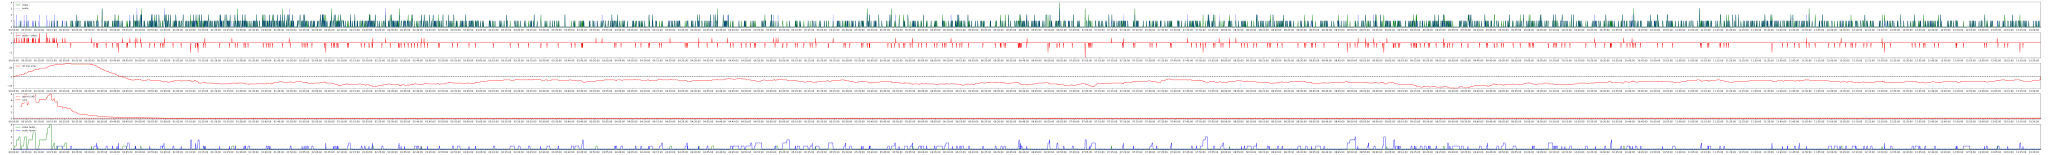

In [11]:
visualize_faults(predictions['n_counts'], labels['n_counts'], from_time, till_time)

### Visualize fault detection before and after finetuning

In [12]:
def get_XY(files: list[str], config: Config, model: nn.Module, head="n_counts"):
    X = []
    Y = []

    datapool = DataPool(files, config)

    dataset = VehicleDataset(datapool, part=Part.WHOLE, config=config)
    loader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
    )

    device = next(model.parameters()).device
    dtype = torch.float16 if config.cuda >= 0 and config.fp16 else torch.float32
    device_type = "cuda" if config.cuda >= 0 else "cpu"

    model.eval()
    with torch.no_grad():
        for tensor, labels in tqdm(loader, leave=True):

            with torch.autocast(device_type=device_type, dtype=dtype):
                tensor = tensor.to(device)

            X.extend(model.features(tensor).detach().cpu().numpy())
            Y.extend(labels[head])

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [13]:
TRAINING_HOURS = 6

T = int(h(TRAINING_HOURS) // config.window_length)

y_pred_nn = predictions['n_counts']
y_true = labels['n_counts']

y_pred_nn = y_pred_nn[T:]
y_true = y_true[T:]

file_name = file if isinstance(file, str) else file[0]
path = f"outputs/{uuid}/svm/{file_name}/model.pkl"

with open(path,'rb') as f:
    classifier = pickle.load(f)

X, Y = get_XY([file], config, model)
X_tst, Y_tst = X[T:], Y[T:]
y_pred_svm = classifier.predict(X_tst)

assert len(y_pred_svm) == len(y_pred_nn)

Output()

  0%|          | 0/32 [00:00<?, ?it/s]

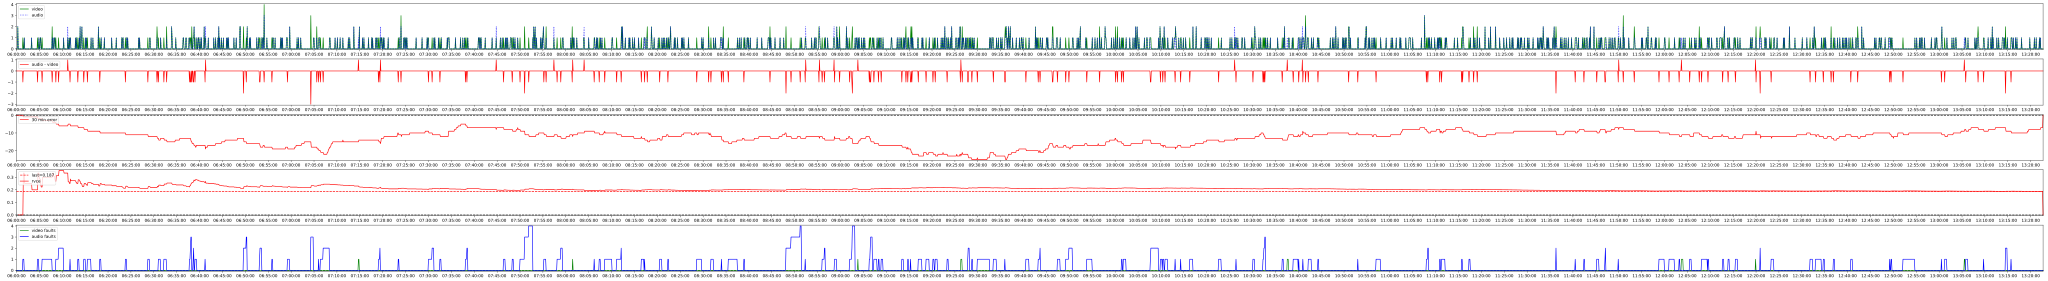

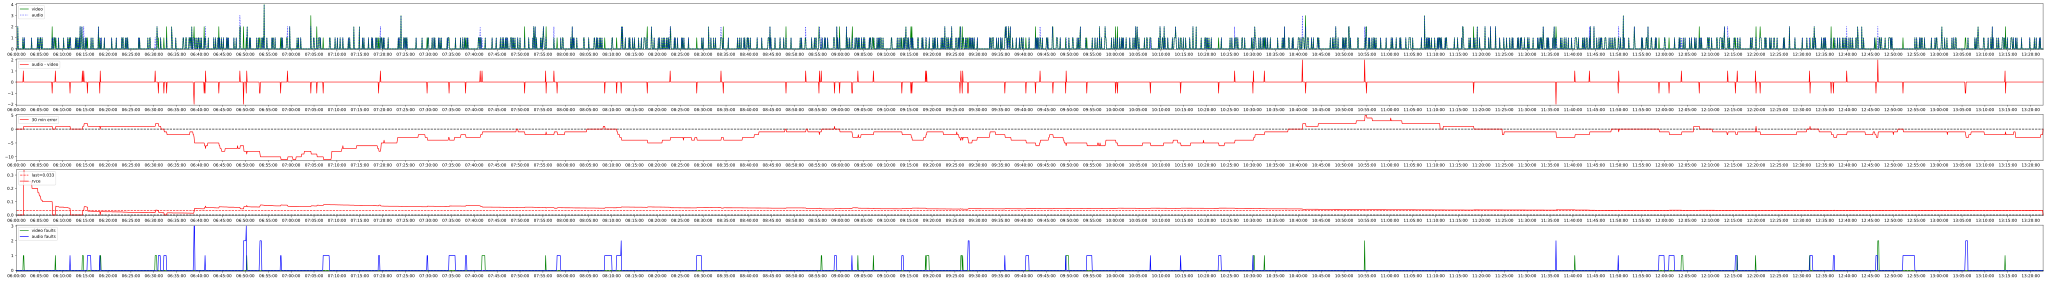

In [14]:
visualize_faults(y_pred_nn, y_true, h(TRAINING_HOURS), till_time)
visualize_faults(y_pred_svm, y_true, h(TRAINING_HOURS), till_time)

pred: 811 	 true: 998 	 rvce: 0.187
pred: 965 	 true: 998 	 rvce: 0.033


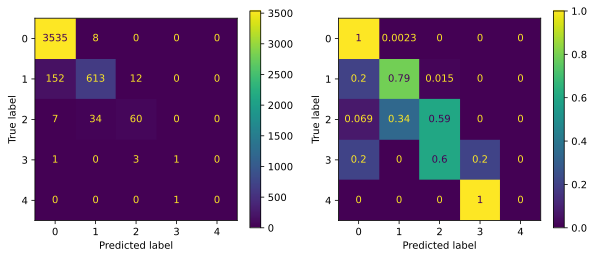

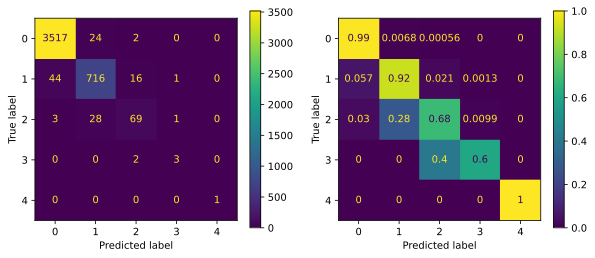

In [15]:
set_plt_svg()
plot_confusion_matrix(y_true, y_pred_nn)
plot_confusion_matrix(y_true, y_pred_svm)